# `2_analysis.ipynb`

This notebook pulls the pre-generated dataframes and network objects which have been generated by `1_ingest.ipynb` from the filesystem and the produces some useful analysis. The list of projects is the same.

- Bored Ape Yacht Club
- Coolcats
- Cryptoadz
- Cyberkongz
- Hashmasks
- Mutant Ape Yacht Club
- Meebits
- Mekaverse
- Sneaky Vampire Syndicate

As the data generation is split from the analysis code, this notebook can be run relatively quickly. Like the first notebook, the notebook is written in a very functional style in order to allow for readability. Plotting functions are declared and then called to minimized bloat. 

# Setup

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import powerlaw

import arrow

from scipy.special import factorial
from math import e

import warnings
warnings.filterwarnings('ignore')

# Config

In [2]:
projects = [
    'bayc', 
    'coolcats', 
    'cryptoadz', 
    'cyberkongz', 
    'hashmasks', 
    'mayc', 
    'meebits', 
    'mekaverse', 
    'svs'
]

# Load Project Data

In [3]:
df_summaries = {}

column_names = [
    "date", 
    "days_since_mint", 
    "from_address", 
    "to_address", 
    "token_id", 
    "blk_number", 
    "eth_value", 
    "usd_value", 
    "from_value", 
    "to_value", 
    "from_value_usd", 
    "to_value_usd"
]

for project in projects:
    np_data = np.load(f"./memory/{project}/full.npy", allow_pickle=True)
    df_summaries[project] = pd.DataFrame(data=np_data, columns=column_names).infer_objects()

# Aggregrate Measures

### Helper function - get project price performance

In [4]:
def get_price_performance_series(project):
    df = df_summaries[project]
    df = df[df['eth_value'] != 0]
    
    df_price = df.groupby('days_since_mint').agg({'token_id': 'count', 'usd_value':'sum'}).reset_index().rename(columns={'token_id':'token_count', 'usd_value': 'aggregrate_usd_value'})
    df_price['usd_per_token'] = df_price['aggregrate_usd_value'] / df_price['token_count']
    
    return (df_price['days_since_mint'], df_price['usd_per_token'])

### ETH inflows over DSM

In [5]:
def plot_eth_over_dsm(dfs):
    sort = lambda x: x.sort_values(by=['days_since_mint'])
    group = lambda x: x.groupby(by=['days_since_mint']).sum()
    
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('ETH Inflows over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        df = group(sort(dfs[keys[i]]))

        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(df.index, df.eth_value, color='b', label="ETH inflows")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("value inflow (ETH)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')
        
    plt.savefig('./output/eth_over_dsm.png')

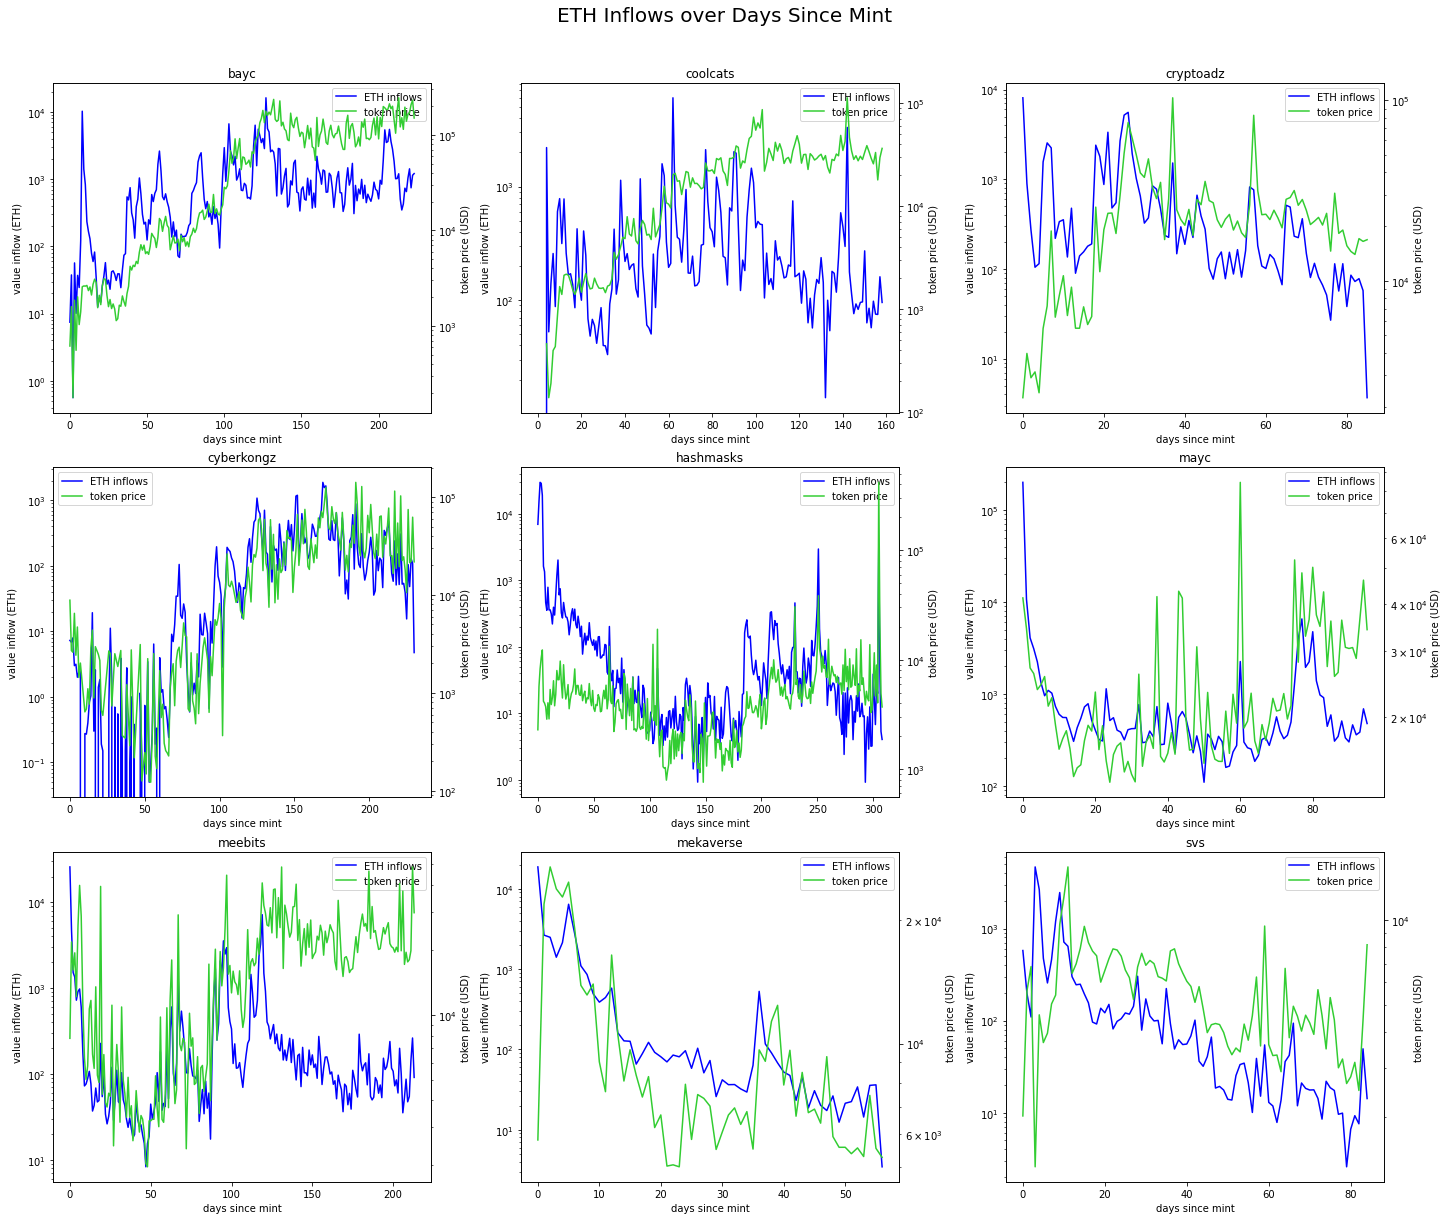

In [6]:
plot_eth_over_dsm(df_summaries)

### Aggregate ETH value over DSM

In [7]:
def get_aggregate_project_value_series(project):
    df = df_summaries[project]
    df_agg = df.groupby('days_since_mint')['eth_value'].sum().reset_index()
    
    x_series = []
    y_series = []
    
    current = 0 
    for i, row in df_agg.iterrows():
        x_series.append(row['days_since_mint'])
        
        current += row['eth_value']
        y_series.append(current)
        
    return (x_series, y_series)

In [8]:
def plot_aggregate_project_value_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Aggregate Project Value over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        agg_x, agg_y = get_aggregate_project_value_series(keys[i])
        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(agg_x, agg_y, color='b', label="aggregate project value")
        ax.set_title(keys[i])
        ax.set_xlabel("days since mint")
        ax.set_ylabel("aggregrate project value (ETH)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')
        
    plt.savefig('./output/aggregate_project_value_over_dsm.png')

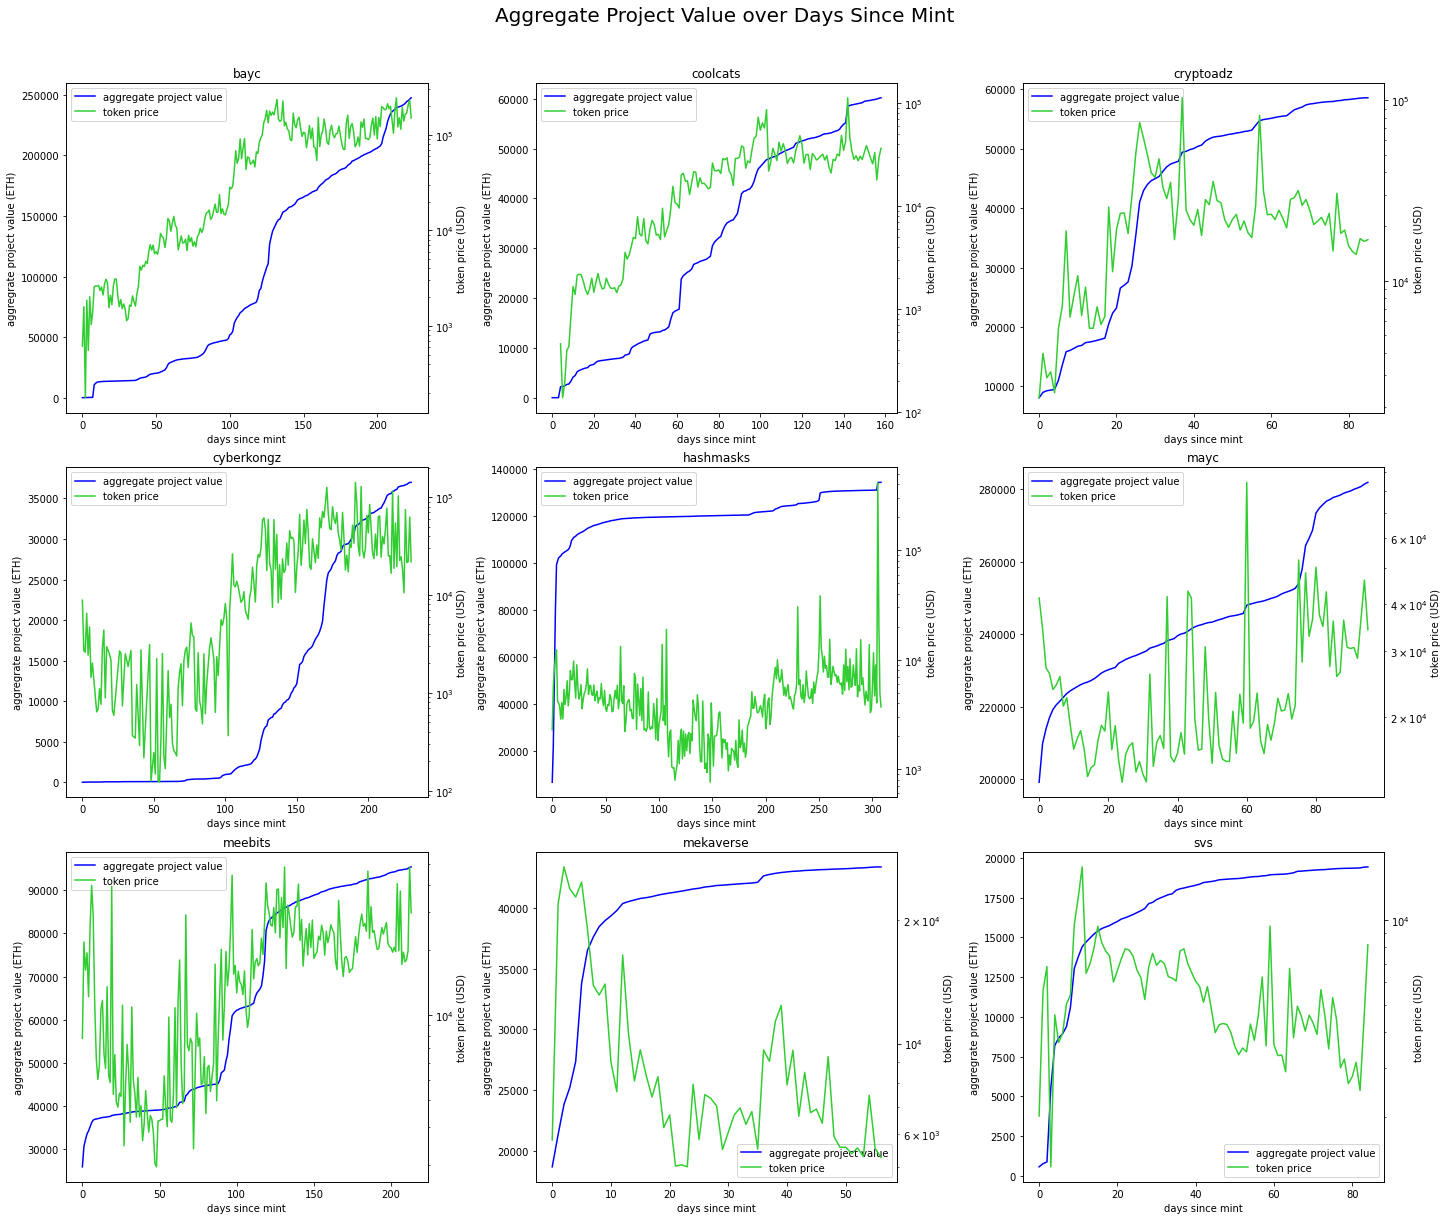

In [9]:
plot_aggregate_project_value_over_dsm(df_summaries)

### USD inflows over DSM

In [10]:
def plot_usd_over_dsm(dfs):
    sort = lambda x: x.sort_values(by=['days_since_mint'])
    group = lambda x: x.groupby(by=['days_since_mint']).sum()
    
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('USD Inflows over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        df = group(sort(dfs[keys[i]]))

        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(df.index, df.usd_value, color='b', label="USD inflows")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("value inflow (USD)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')
        
    plt.savefig('./output/usd_over_dsm.png')

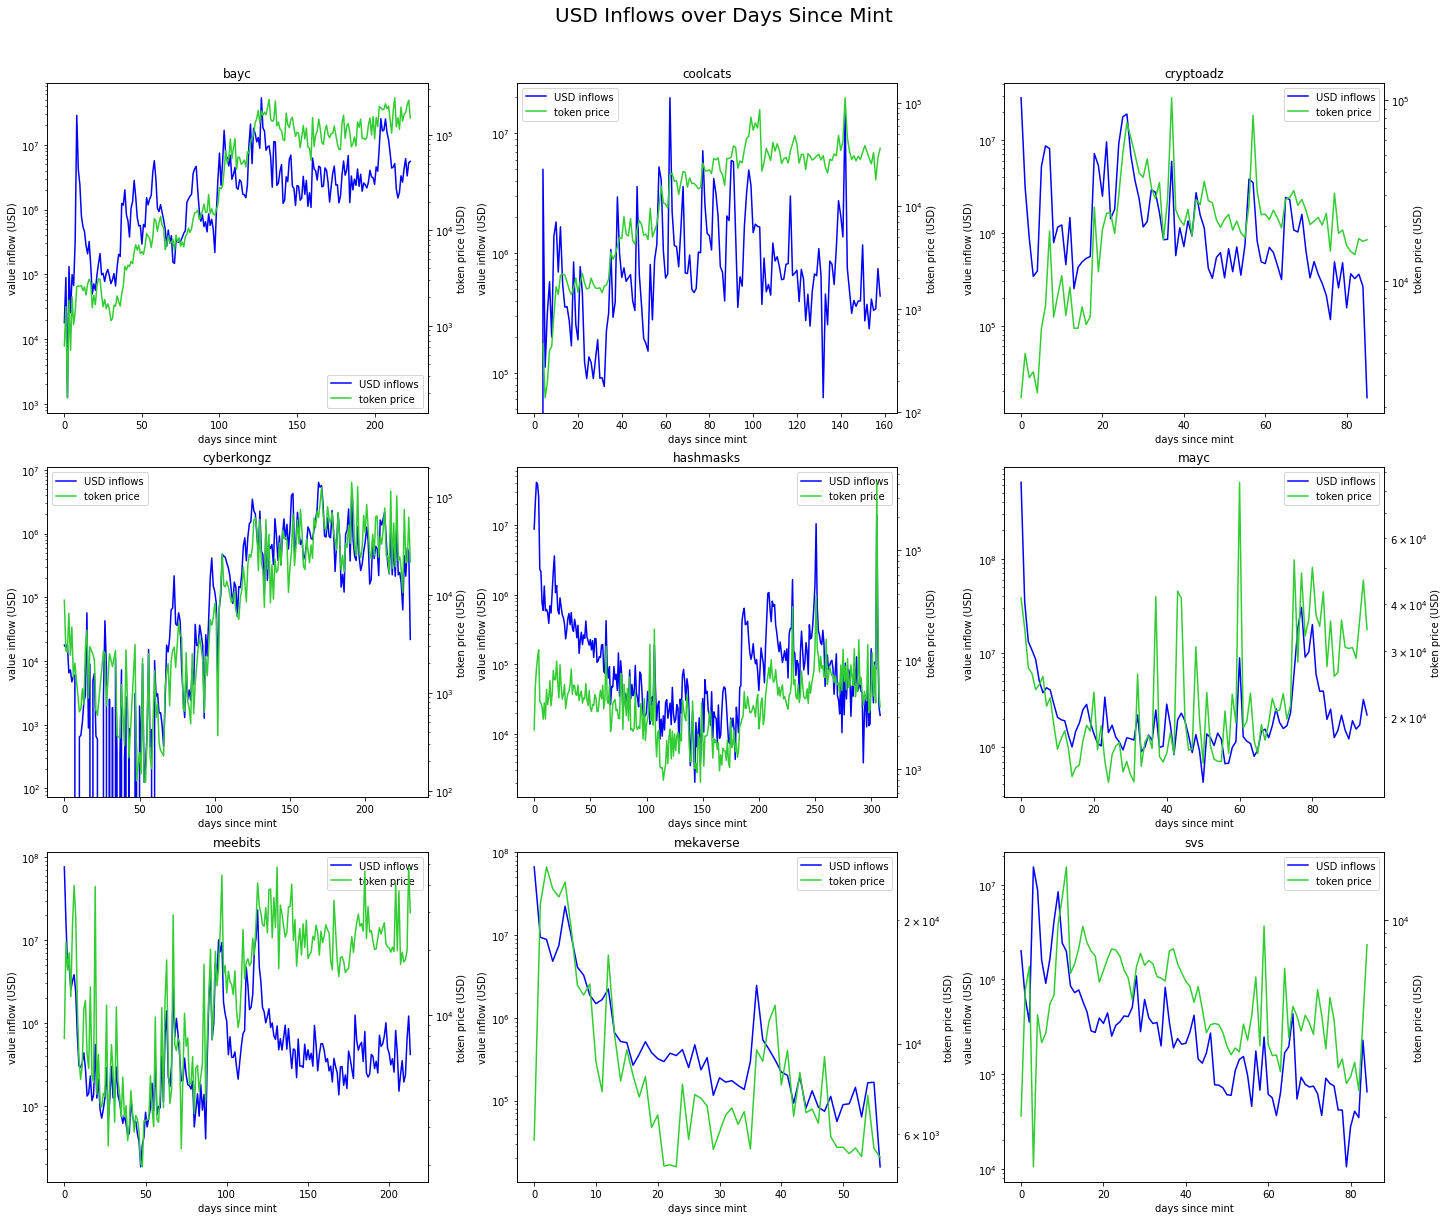

In [11]:
plot_usd_over_dsm(df_summaries)

### Number of transactions over DSM

In [12]:
def plot_transactions_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Transactions over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        df = dfs[keys[i]]

        price_x, price_y = get_price_performance_series(keys[i])

        ax.hist(df.days_since_mint, bins=100, color='b', label="transactions")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("number of transactions")

        ax_twin = ax.twinx()
        ln1 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')
        
    plt.savefig('./output/transactions_over_dsm.png')

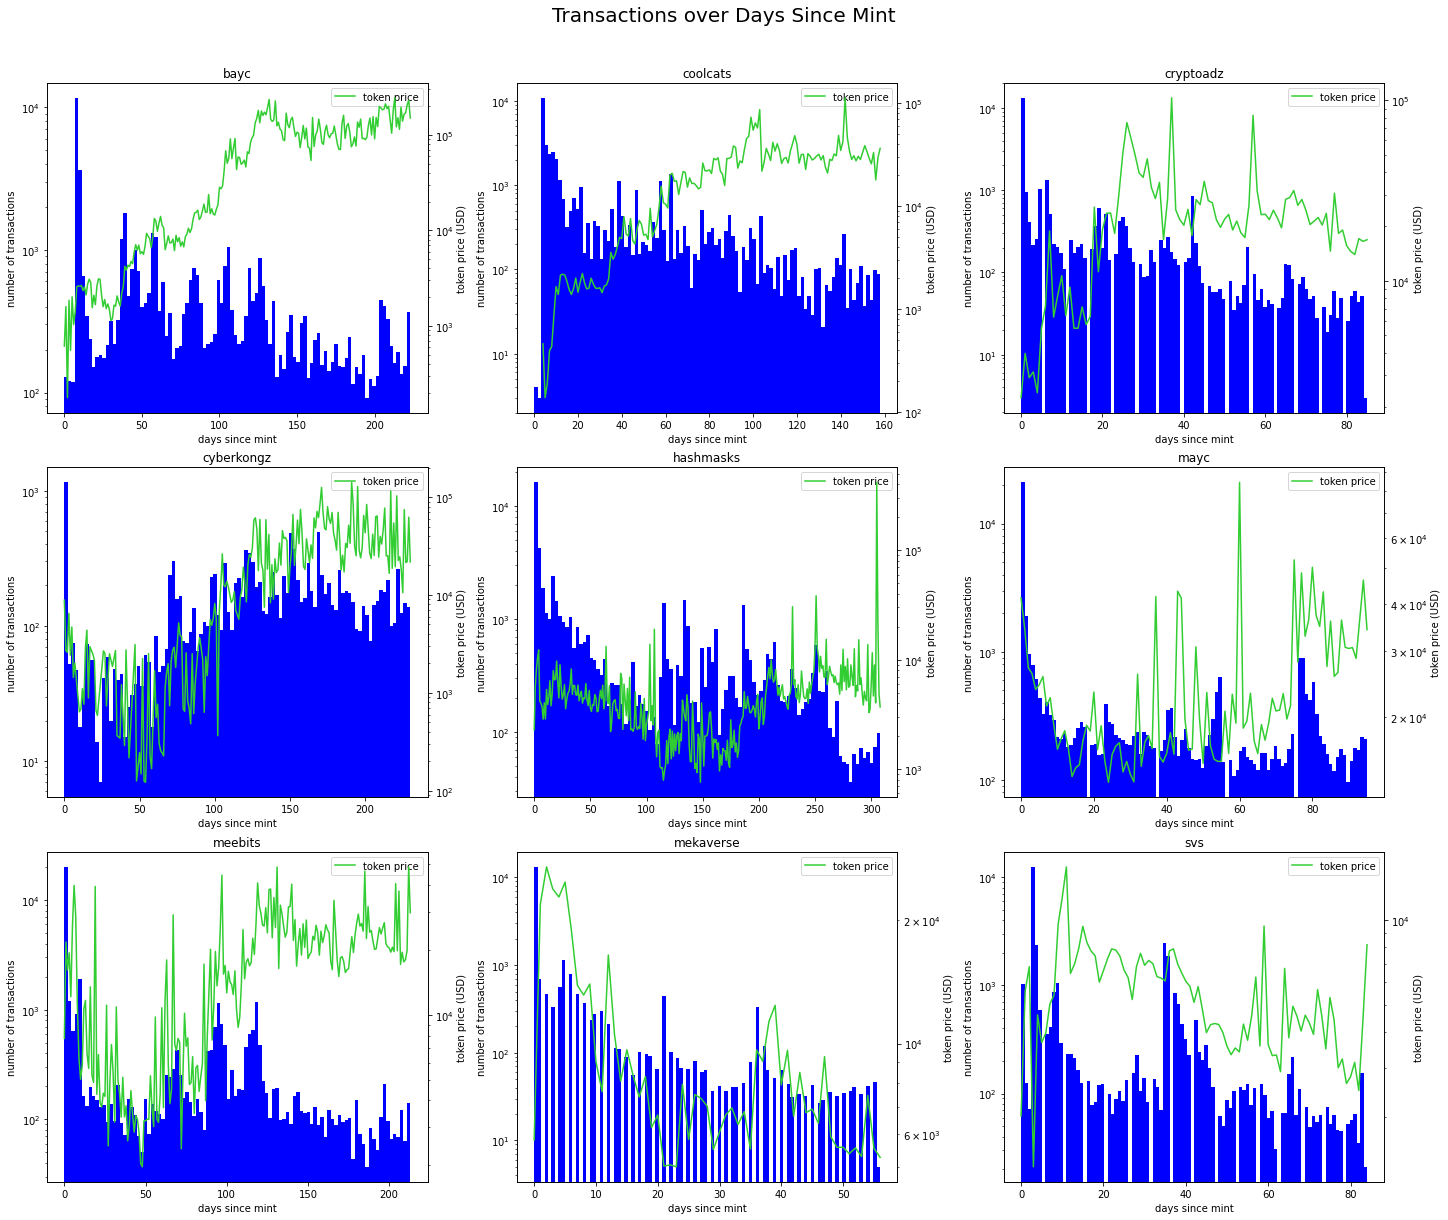

In [13]:
plot_transactions_over_dsm(df_summaries)

### Unique holders over DSM

In [14]:
def get_unique_holders_series(project):
    df = df_summaries[project]
    df_holders = df.groupby('days_since_mint')['from_address', 'to_address']
    
    x_series = []
    y_series = []
    
    uniques = set()
    for name, group in df_holders:
        for i, row in group.iterrows():
            uniques.add(row['from_address'])
            uniques.add(row['to_address'])
        
        x_series.append(name)
        y_series.append(len(uniques))
        
    return (x_series, y_series)

In [15]:
def plot_unique_holders_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Unique Holders over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        unique_x, unique_y = get_unique_holders_series(keys[i])
        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(unique_x, unique_y, color='b', label="unique holders")
        ax.set_title(keys[i])
#         ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("unique holders")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')
        
    plt.savefig('./output/unique_holders_over_dsm.png')

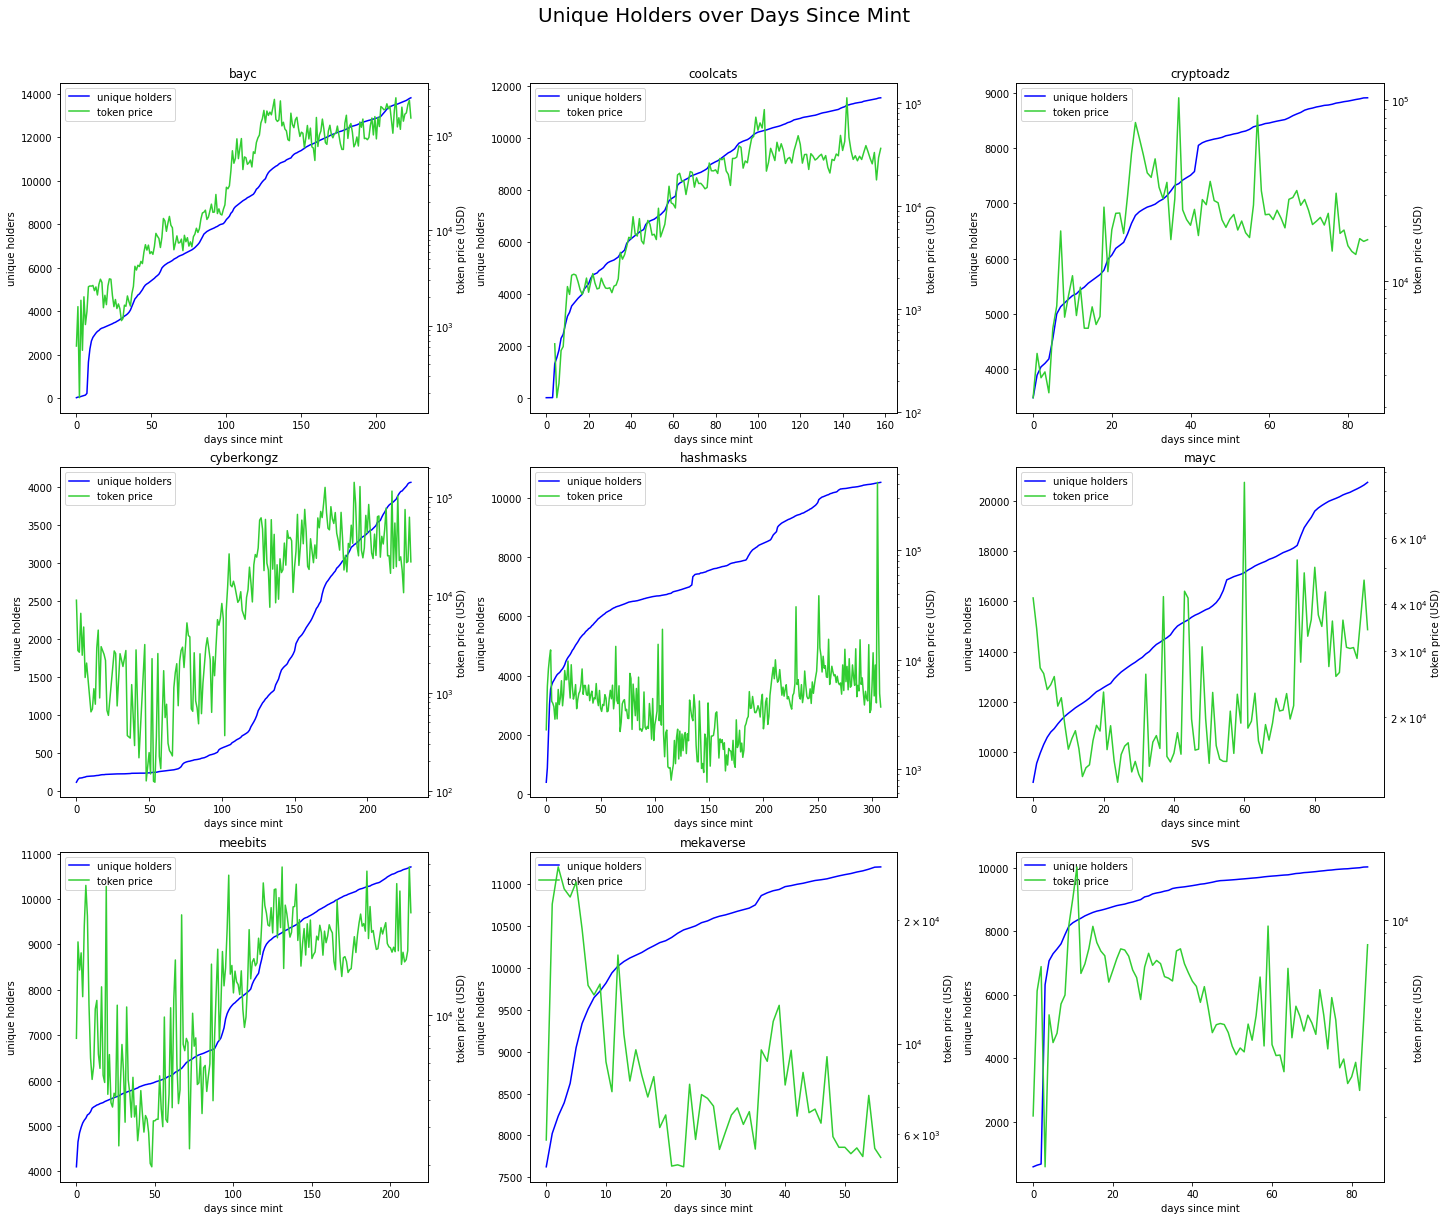

In [16]:
plot_unique_holders_over_dsm(df_summaries)

### Aggregate holder ETH value over DSM (Whale Watching)

In [17]:
def get_aggregate_holder_value_series(project):
    ZERO_ADDRESS = '0x0000000000000000000000000000000000000000'
    
    df = df_summaries[project]
    df_agg = df.groupby('days_since_mint')
    
    x_series = []
    y_series = []
    
    already_seen = set()
    
    # Clever trick - we add the 0x0 address here
    already_seen.add(ZERO_ADDRESS)
    
    current = 0
    for name, group in df_agg:
        for i, row in group.iterrows():
            from_address = row['from_address']
            to_address = row['to_address']
            
            from_value = row['from_value'] if not from_address in already_seen else 0
            to_value = row['to_value'] if not to_address in already_seen else 0
            
            already_seen.add(from_address)
            already_seen.add(to_address)
            
            current += (from_value + to_value)
        
        x_series.append(name)
        y_series.append(current)
        
    return (x_series, y_series)

In [18]:
def plot_aggregate_holder_value_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Aggregate Holder Value over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        agg_x, agg_y = get_aggregate_holder_value_series(keys[i])
        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(agg_x, agg_y, color='b', label="aggregate holder value")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("aggregrate holder value (ETH)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')
        
    plt.savefig('./output/aggregate_holder_value_over_dsm.png')

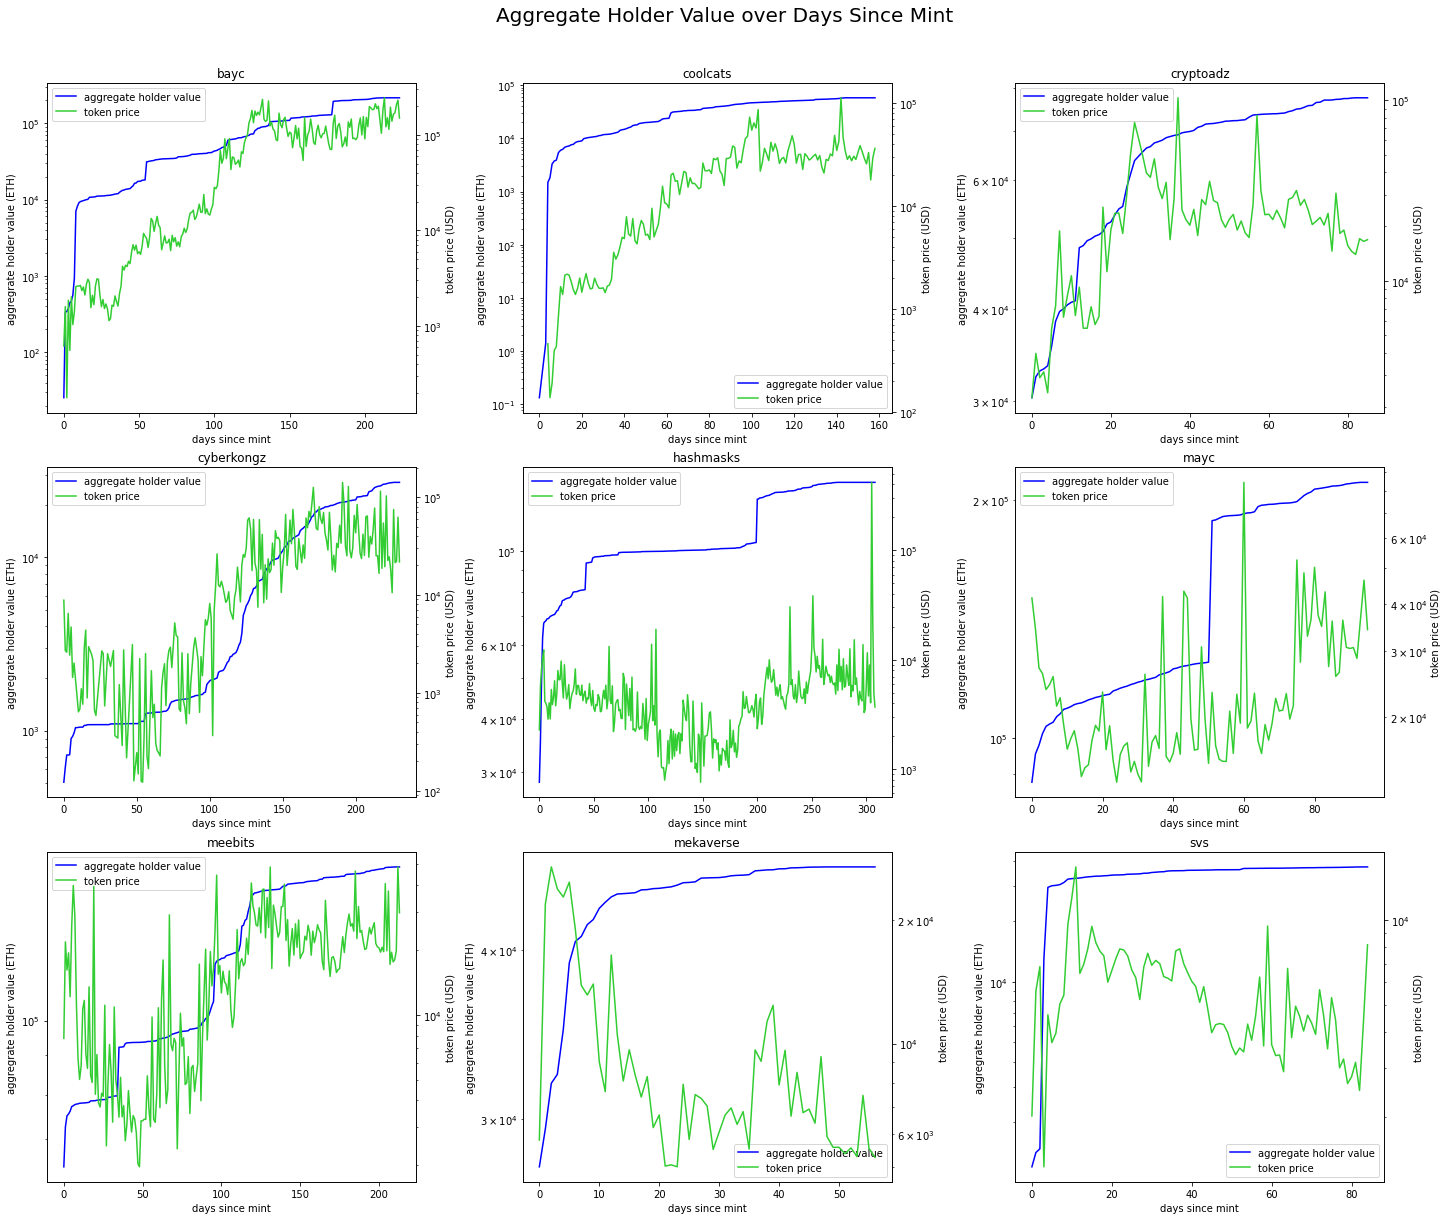

In [19]:
plot_aggregate_holder_value_over_dsm(df_summaries)

# Network Measures

### Load data

In [20]:
df_snapshots = {}

column_names = [
    "time_bucket", 
    "time_bucket_label",
    "number_of_nodes", 
    "degree",
    "density",
    "reciprocity", 
    "assortativity", 
    "assortativity_base", 
    "assortativity_out_out", 
    "assortativity_in_in", 
    "assortativity_in_out",
    "centrality_degree",
    "centrality_closeness"
]

for project in projects:
    np_data = np.load(f"./memory/{project}/snapshots/summary.npy", allow_pickle=True)
    df = pd.DataFrame(data=np_data, columns=column_names).infer_objects()
    
    initial_date = df.head(1)['time_bucket_label'][0].date()
    
    for i, row in df.iterrows():
        days_since_mint = (row['time_bucket_label'].date() - initial_date).days
        df.loc[i, 'days_since_mint'] = days_since_mint
    
    df_snapshots[project] = df

### Helper to plot snapshot characteristics

In [21]:
attribute_names = {
    "degree": "Average Degree",
    "density": "Density",
    "reciprocity": "Reciprocity",
    "assortativity": "Assortativity", 
    "assortativity_base": "Undirected Assortativity", 
    "assortativity_out_out": "Out-Out Assortativity", 
    "assortativity_in_in": "In-In Assortativity", 
    "assortativity_in_out": "In-Out Assortativity",
    "centrality_degree": "Degree Centrality",
    "centrality_closeness": "Closeness Centrality", 
}

In [22]:
def plot_snapshot_attribute_over_time_bucket(dfs, attribute):
    fig, axs = plt.subplots(1, figsize=(12, 8), constrained_layout=True)
    fig.suptitle(f'Network {attribute_names[attribute]} over Normalized Time Buckets', y=1.05, fontsize=20)
    
    for key in dfs.keys():
        df = dfs[key]
        y = df[attribute]
        
        if attribute == 'degree':
                y_series = []
                for entry in y:
                    temp = []
                    for address, degree in entry:
                        temp.append(degree)
                    y_series.append(sum(temp)/len(temp))
                    
                y = y_series
    
        if attribute in ['centrality_degree', 'centrality_closeness']:
            y_series = []
            for entry in y:
                temp = []
                for x in entry.values():
                    temp.append(x)
                y_series.append(sum(temp)/len(temp))
                
            y = y_series
        
        plt.plot(df.time_bucket, y, label=key)
        
    plt.xlabel("Normalized Time Bucket", fontsize=18)
    plt.ylabel(attribute_names[attribute], fontsize=18)
        
    plt.legend()
    plt.savefig(f'./output/{attribute}.png')

### Average degree

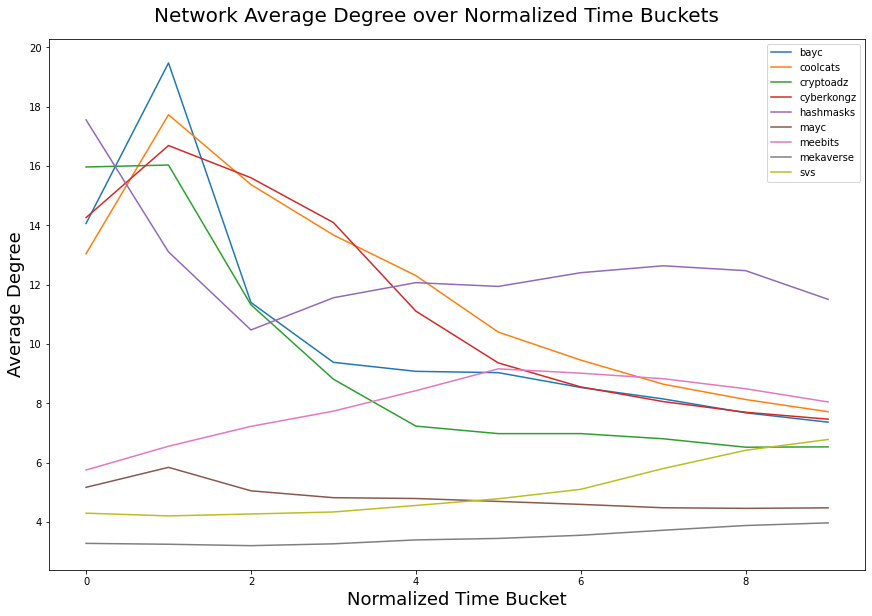

In [23]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "degree")

### Density

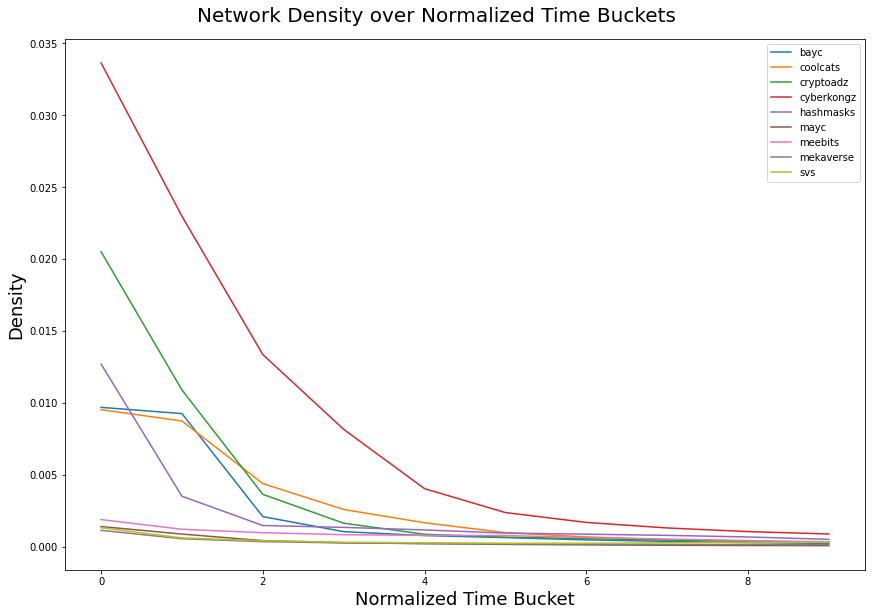

In [24]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "density")

### Assortativity

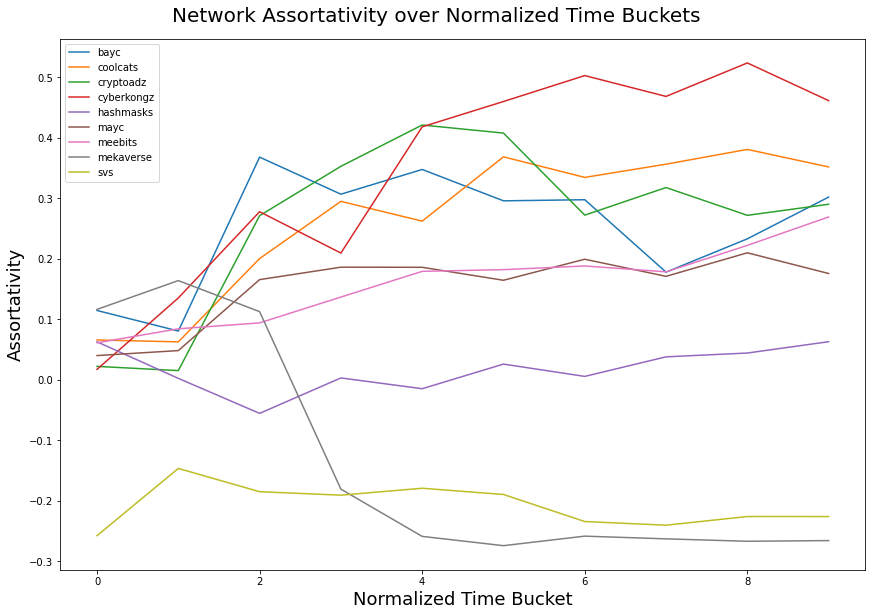

In [25]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "assortativity")

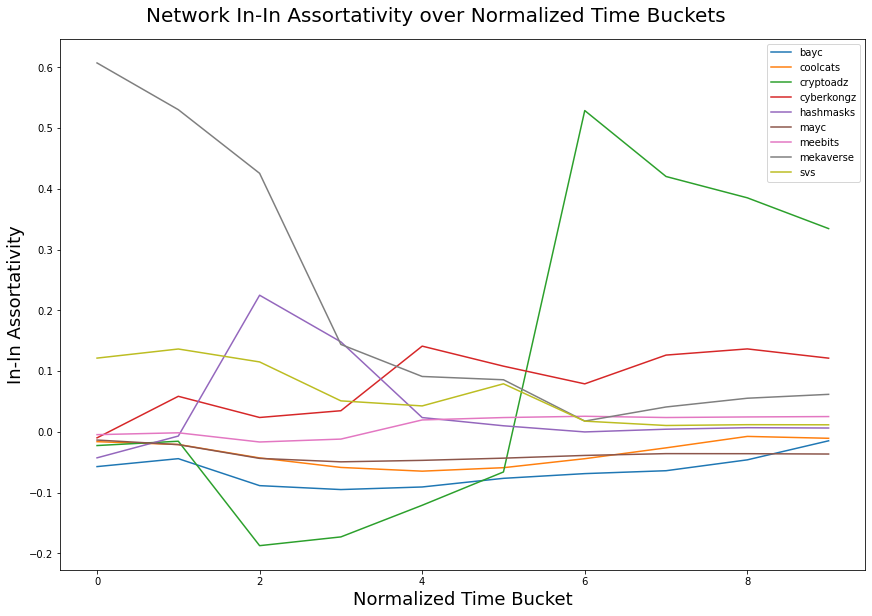

In [26]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "assortativity_in_in")

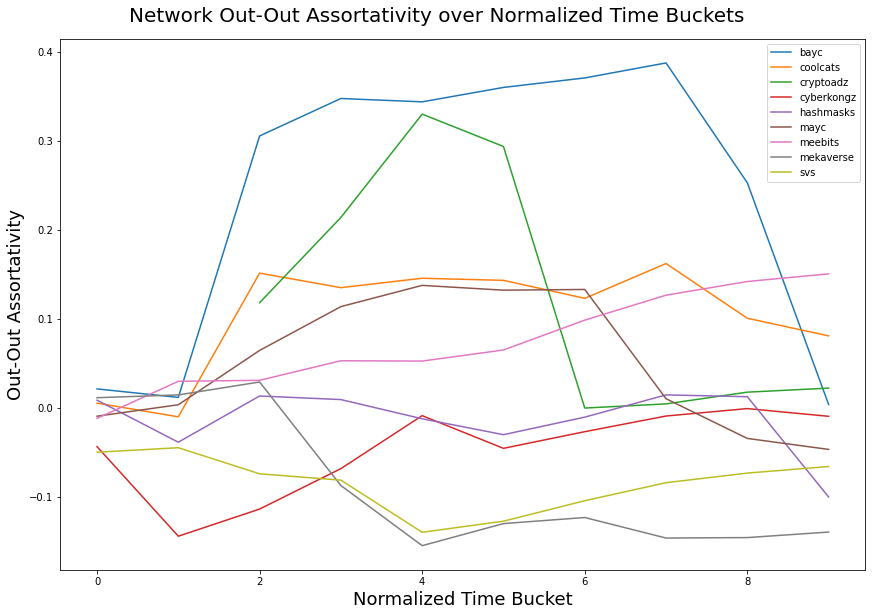

In [27]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "assortativity_out_out")

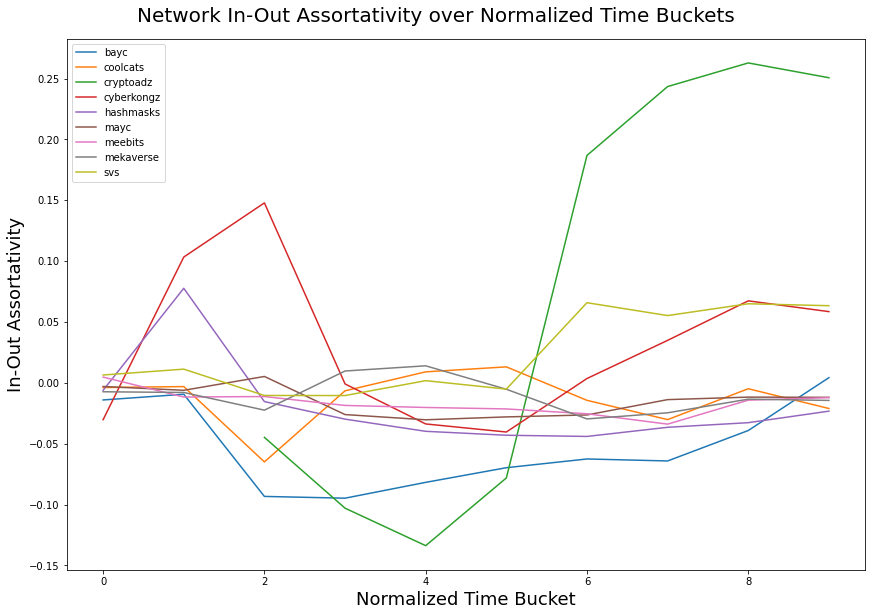

In [28]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "assortativity_in_out")

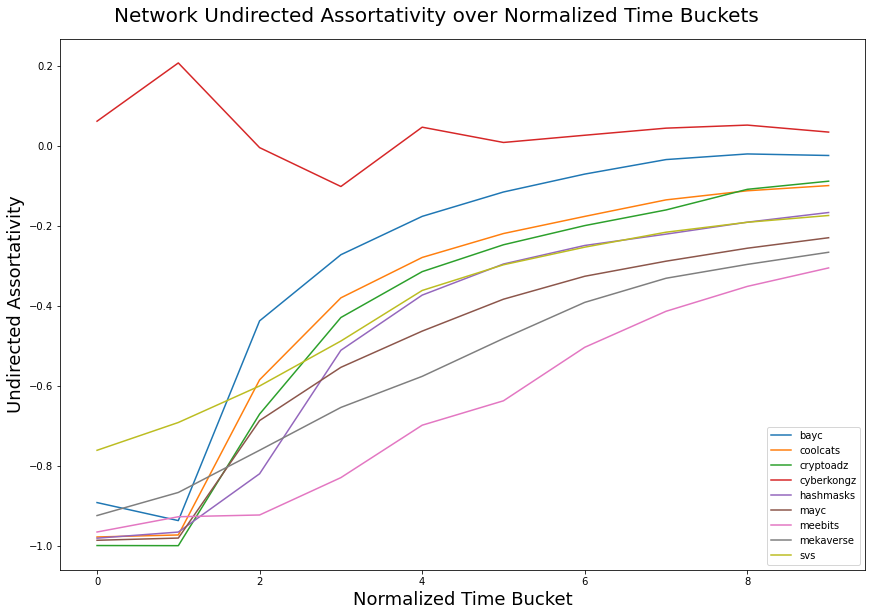

In [29]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "assortativity_base")

### Centrality

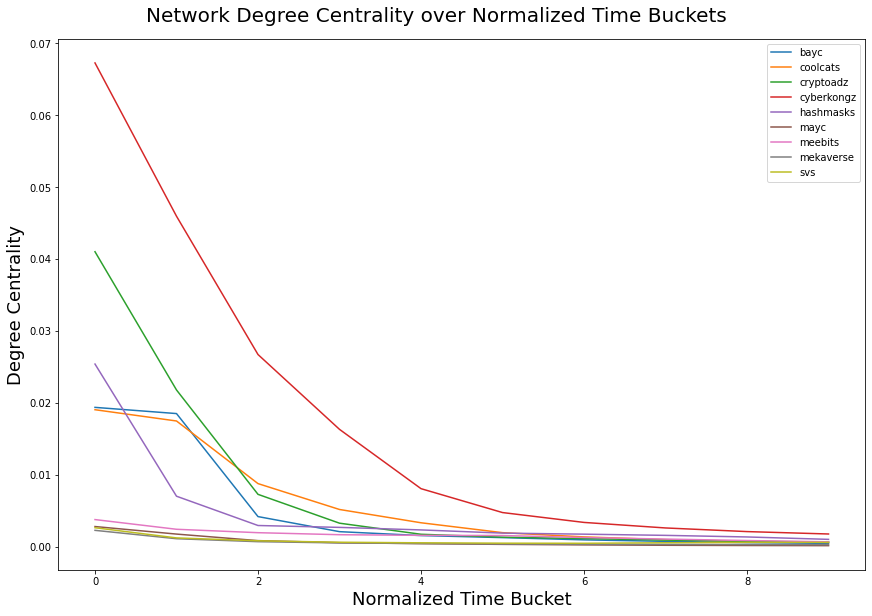

In [30]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "centrality_degree")

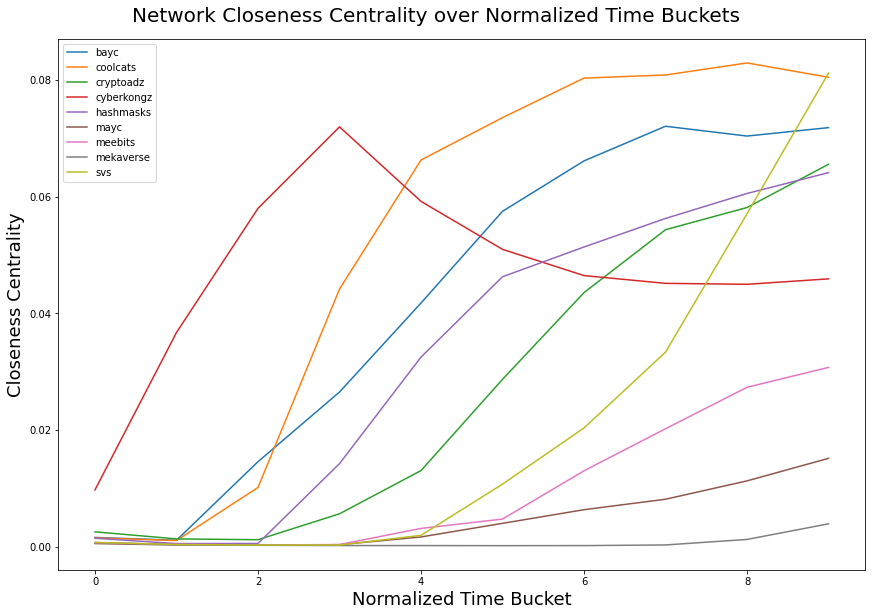

In [31]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "centrality_closeness")

### Reciprocity

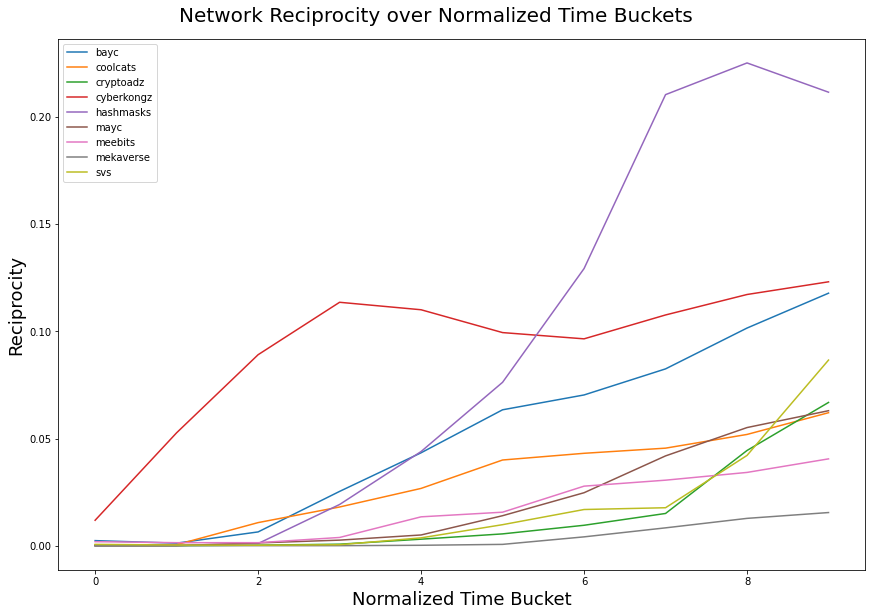

In [32]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "reciprocity")

### Power law analysis

In [33]:
final_graphs = {}

for project in projects:
    final_graphs[project] = nx.readwrite.gml.read_gml(f'./memory/{project}/snapshots/9.gml')

In [34]:
def pure(x, alpha):
    return x**(-alpha)

def poisson(k, avg_degree):
    return (np.exp(-1 * avg_degree) * np.power(avg_degree, k)) / factorial(k)

def exp(k, avg_degree):
    return ((1/avg_degree) * np.exp((k * (-1)) / avg_degree))

def round_float(x):
    if x in [float("-inf"),float("inf")]: return float(0)
    return x

In [35]:
def plot_graph_power_laws(gs):
    keys = [key for key in gs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Power Law Analysis', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        g = gs[keys[i]]
        
        k = np.asarray([d for d in dict(g.degree()).values()])
        avg_degree = sum(k) / len(g.nodes())

        spacing = np.linspace(min(k), max(k), len(k))

        fit = powerlaw.Fit(k, suppress_output=True)

        alpha = fit.power_law.alpha
        sigma = fit.power_law.sigma

        powerlaw.plot_pdf(k, ax=ax, color='b', marker='o', label='PDF')
        fit.power_law.plot_pdf(ax=ax, color='b', linestyle='--', label="Fit PDF")
        
        ax.plot(spacing, pure(spacing, alpha), color='r', label='Pure alpha Fit')
        ax.plot(spacing, poisson(spacing, avg_degree), color='g', label="Poisson Dist.")
        ax.plot(spacing, exp(spacing, avg_degree), color='orange', label="Exponential Dist.")

        ax.set_xscale('log')
        
        ax.legend()
        ax.set_title(keys[i])

        ax.set_xlabel("k")
        ax.set_ylabel("p(k)")

        ax.annotate("alpha: {:.2f}\nsigma: {:.2f}".format(alpha, sigma), xy=(0.80, 0.70), xycoords='axes fraction')

        ax.set_ylim(0.000000001, 1)
        
    plt.savefig(f'./output/graph_power_laws.png')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


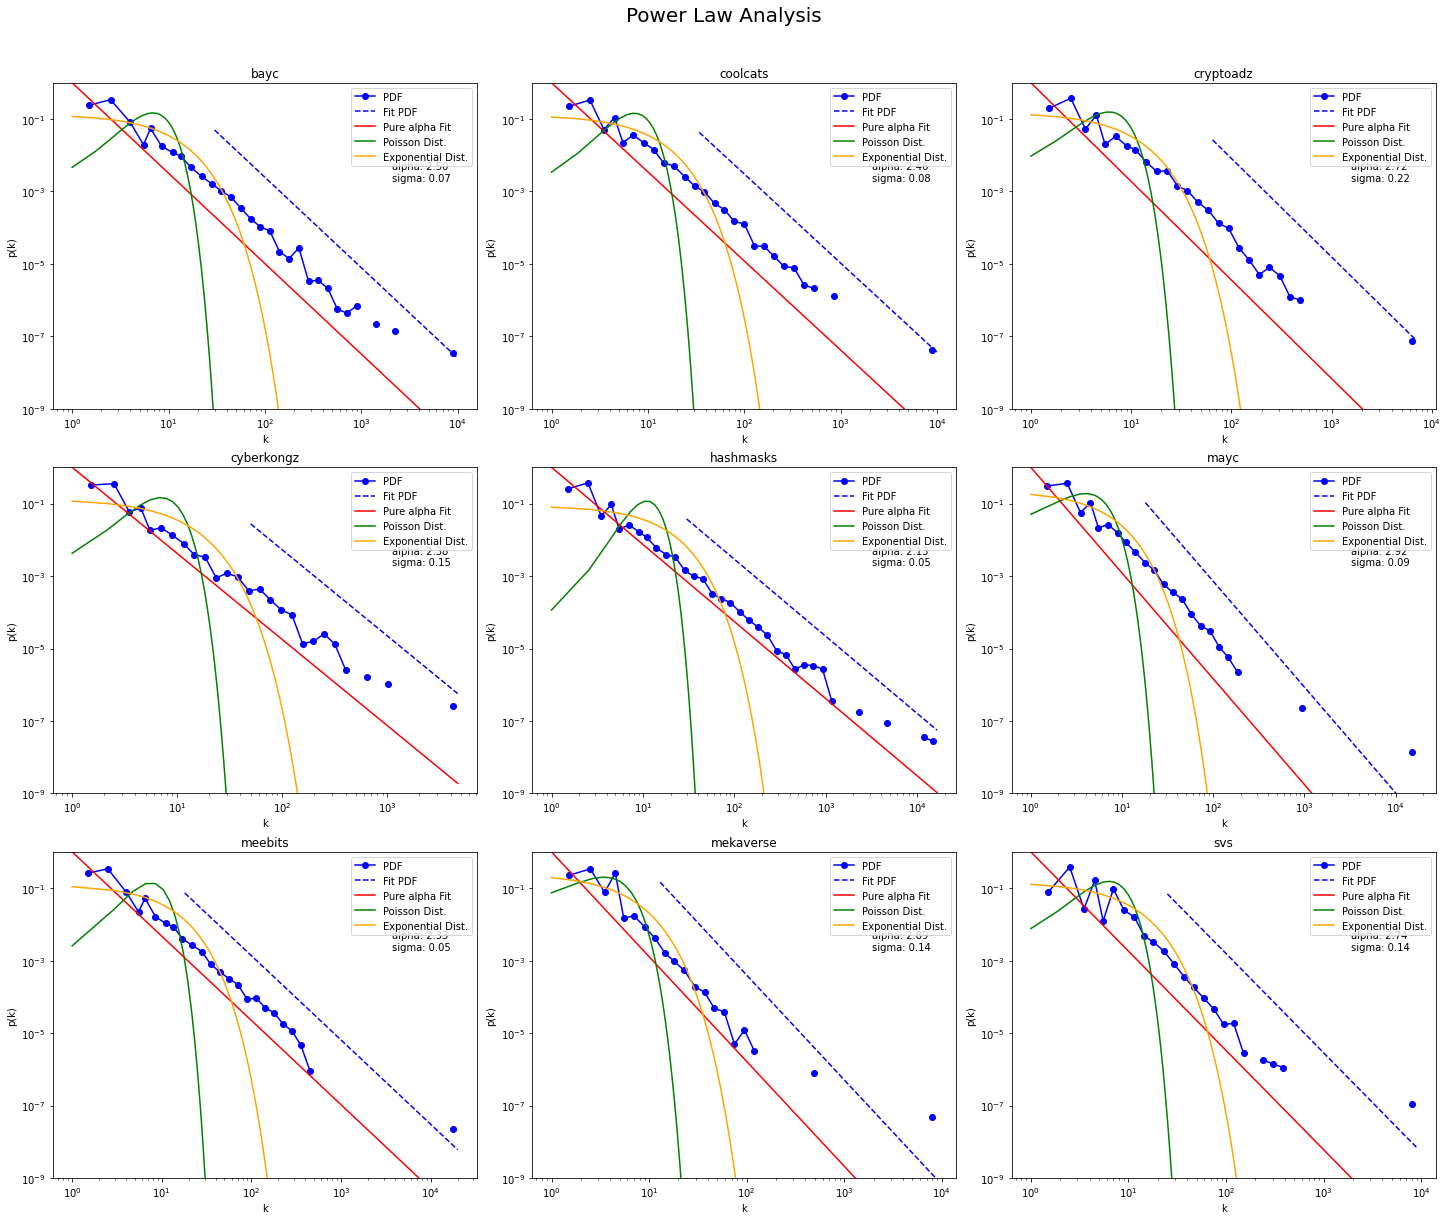

In [36]:
plot_graph_power_laws(final_graphs)

### Helper plot for report

In [37]:
def plot_all_price_performance():
    fig, axs = plt.subplots(1, figsize=(12, 8), constrained_layout=True)
    fig.suptitle(f'Network Price Performance over Days Since Mint', y=1.05, fontsize=20)
    
    for project in projects:
        x_series, y_series = get_price_performance_series(project)
        plt.plot(x_series, y_series, label=project)
        
    plt.xlabel("Days Since Mint", fontsize=18)
    plt.ylabel("Price", fontsize=18)
    
    plt.yscale("log")
        
    plt.legend()
    plt.savefig(f'./output/price_performance.png')

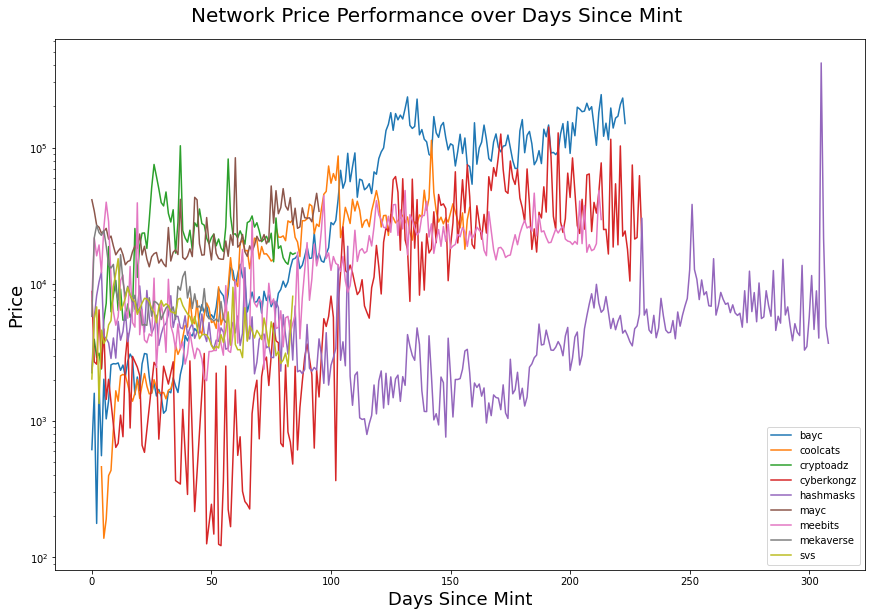

In [38]:
plot_all_price_performance()